# Задача 5: Обучение без учителя

- [X] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [X] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [X] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [X] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [X] При обучении использовать **подбор гиперпараметров**.
- [X] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [X] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [X] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

## EDA

Был выбран датасет "Covertype", содержащий информацию о типах лесного покрова и их характерных призанаках

In [1]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
y = covertype.data.targets

# metadata
print(covertype.metadata)

# variable information
print(covertype.variables)


{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

In [2]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Soil_Type1                          581012 non-null 

In [3]:
len(y["Cover_Type"].unique())

7

In [4]:
X.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0
Soil_Type12                           0
Soil_Type13                           0
Soil_Type14                           0


In [5]:
len(X.head().columns)

54

Итого:
- Датасет не содержит дефектов в виде отстутствующих данных
- Датасет содержит почти 600000 строк (данное количество является слишком большим в рамках задания, и поэтому будет уменьшено) и 54 столбца (признака)
- Всего в датасете есть 7 классов лесного покрытия (данное число будет использоваться как количество кластеров)

Посмотрим, какое количество кластеров было бы оптимальным, согласно методу локтя

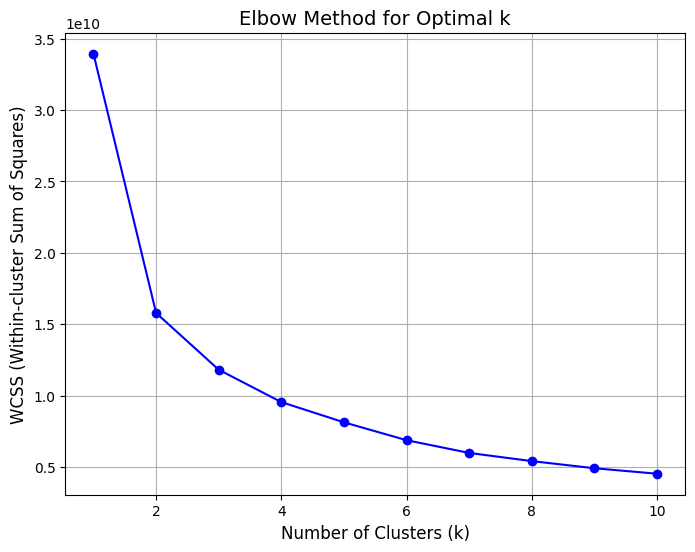

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
for n_clusters in range(1, 11):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        max_iter=300,
        n_init=10,
        random_state=42,
    )
    kmeans.fit(X.values[:10000])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker="o", color="b")
plt.title("Elbow Method for Optimal k", fontsize=14)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("WCSS (Within-cluster Sum of Squares)", fontsize=12)
plt.grid(True)
plt.show()

Согласно методу локтя, оптимальным количеством кластеров было бы 4,5,6 или же 7. Так как 7 является заранее известным количеством искомых классов, дальше будем использовать его.

Также сократим размеры датасета для того, чтобы снизить количество потребляемых ресурсов.

In [7]:
new_y = y["Cover_Type"][:10000]
new_X = X.values[:10000]

### PCA + t-SNE

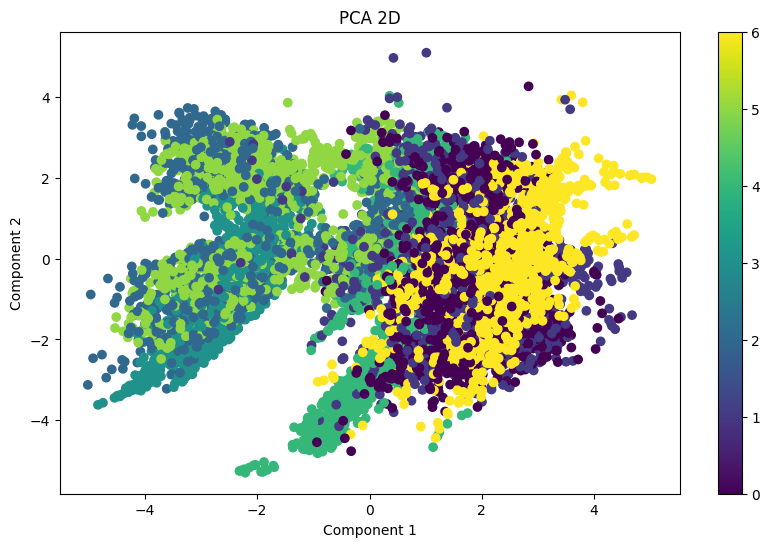

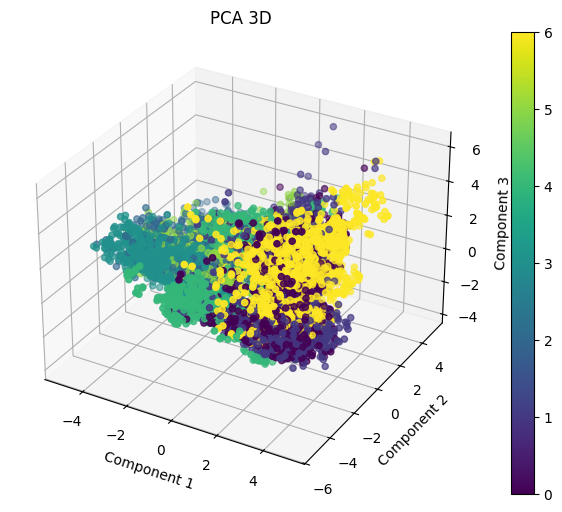

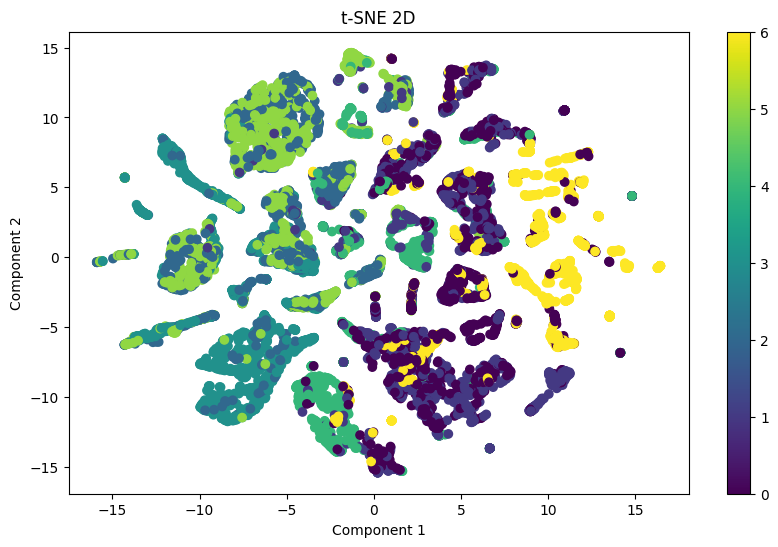

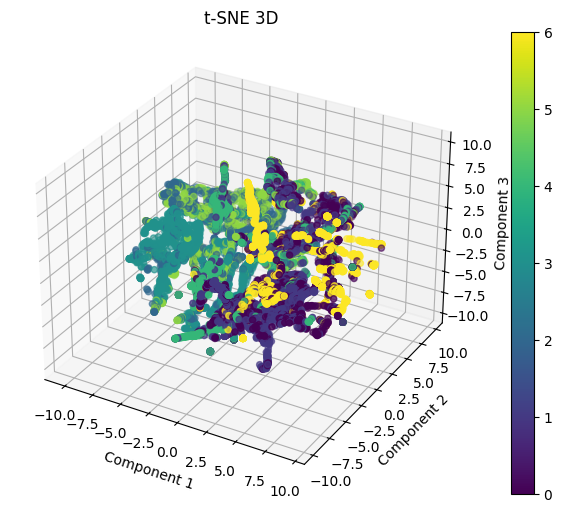

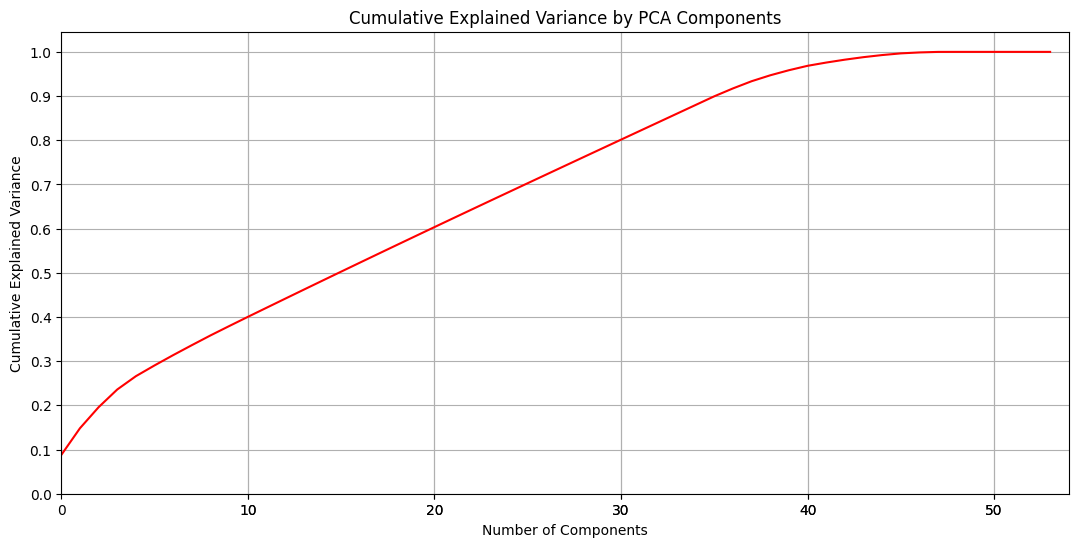

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np

features = X.values[:10000]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(features_scaled)

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(features_scaled)

tsne_2d = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=42)
tsne_result_2d = tsne_2d.fit_transform(features_scaled)

tsne_3d = TSNE(n_components=3, perplexity=30, max_iter=300, random_state=42)
tsne_result_3d = tsne_3d.fit_transform(features_scaled)


def plot_2d(result, title, new_y):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        result[:, 0],
        result[:, 1],
        c=new_y.astype("category").cat.codes,
        cmap="viridis",
    )
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


def plot_3d(result, title, new_y):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(
        result[:, 0],
        result[:, 1],
        result[:, 2],
        c=new_y.astype("category").cat.codes,
        cmap="viridis",
    )
    plt.colorbar(scatter)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    plt.show()


plot_2d(pca_result_2d, "PCA 2D", new_y)
plot_3d(pca_result_3d, "PCA 3D", new_y)

plot_2d(tsne_result_2d, "t-SNE 2D", new_y)
plot_3d(tsne_result_3d, "t-SNE 3D", new_y)

pca_full = PCA()
pca_full.fit(features_scaled)

plt.figure(figsize=(13, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), color="red")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(list(plt.xticks()[0]) + [10, 20, 30, 40, 50])
plt.xlim(0, len(pca_full.explained_variance_ratio_))
plt.grid(True)
plt.title("Cumulative Explained Variance by PCA Components")
plt.show()


Согласно графику, с помощью 30 признаков возможно описать 80% дисперсии, с помощью 35 - 90%, с помощью 40 - примерно 96% и с помощью 45 - примерно 100%. Учтем это на будущее.

## Своя реализация K-Means

In [ ]:
import time


class My_KMeans:
    def __init__(
        self, n_clusters=1, max_iter=100, tol=1e-4, n_init=10, random_state=None
    ):
        """
        Initialize the KMeans instance.
        """
        self.k = n_clusters
        self.max_iterations = max_iter
        self.tol = tol
        self.n_init = n_init
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.n_iterations = 0
        self.inertia = None

        if random_state is not None:
            np.random.seed(random_state)

    def _euclidean_distance(self, point1, point2):
        """Calculate the Euclidean distance between two points."""
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _initialize_centroids(self, data):
        """Initialize k centroids randomly from the data points."""
        n_samples = data.shape[0]
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        return data[random_indices].copy()

    def _assign_clusters(self, data, centroids):
        """
        Assign each data point to the nearest centroid.
        """
        n_samples = data.shape[0]
        labels = np.zeros(n_samples, dtype=int)
        squared_distances = np.zeros(n_samples)

        for i in range(n_samples):
            distances = [
                self._euclidean_distance(data[i], centroid) for centroid in centroids
            ]
            labels[i] = np.argmin(distances)
            squared_distances[i] = distances[labels[i]] ** 2

        inertia = np.sum(squared_distances)
        return labels, inertia

    def _update_centroids(self, data, labels):
        """
        Update centroids based on the mean of points in each cluster.
        """
        n_features = data.shape[1]
        new_centroids = np.zeros((self.k, n_features))

        for cluster in range(self.k):
            cluster_points = data[labels == cluster]
            if len(cluster_points) > 0:  # Avoid division by zero
                new_centroids[cluster] = np.mean(cluster_points, axis=0)
            else:
                # If a cluster is empty, randomly reinitialize the centroid
                random_idx = np.random.randint(0, data.shape[0])
                new_centroids[cluster] = data[random_idx]

        return new_centroids

    def _single_run(self, data, init_centroids=None):
        """
        Perform a single run of K-means.
        """
        if init_centroids is None:
            centroids = self._initialize_centroids(data)
        else:
            centroids = init_centroids.copy()

        prev_centroids = None
        iterations = 0

        while iterations < self.max_iterations:
            labels, inertia = self._assign_clusters(data, centroids)

            new_centroids = self._update_centroids(data, labels)

            if prev_centroids is not None:
                centroid_shift = sum(
                    self._euclidean_distance(prev_centroids[i], new_centroids[i])
                    for i in range(self.k)
                )
                if centroid_shift < self.tol:
                    break

            prev_centroids = centroids.copy()
            centroids = new_centroids
            iterations += 1

        labels, inertia = self._assign_clusters(data, centroids)

        return labels, centroids, inertia, iterations

    def fit(self, data):
        """
        Fit the K-means model to the data, running multiple initializations.
        """
        best_labels = None
        best_centroids = None
        best_inertia = float("inf")
        best_n_iterations = 0

        if self.random_state is not None:
            np.random.seed(self.random_state)

        start_time = time.time()

        for i in range(self.n_init):
            if self.random_state is not None:
                run_seed = self.random_state + i
                np.random.seed(run_seed)

            labels, centroids, inertia, iterations = self._single_run(data)

            if inertia < best_inertia:
                best_labels = labels
                best_centroids = centroids
                best_inertia = inertia
                best_n_iterations = iterations

        end_time = time.time()

        self.labels = best_labels
        self.centroids = best_centroids
        self.inertia = best_inertia
        self.n_iterations = best_n_iterations
        self.fitting_time = end_time - start_time

        return self

    def predict(self, data):
        """
        Predict the closest cluster for each sample in data.
        """
        if self.centroids is None:
            raise Exception("Model not fitted yet. Call 'fit' before using 'predict'.")

        labels, _ = self._assign_clusters(data, self.centroids)
        return labels

    def fit_predict(self, data):
        """
        Fit the K-means model and predict cluster labels.
        """
        self.fit(data)
        return self.labels

## Подбор гиперпараметров, подсчет метрик, времени необходимого для тренировки моделей, сравнительные графики

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from sklearn.cluster import KMeans as SKLearnKMeans, AffinityPropagation
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA  # For dimensionality reduction
import pandas as pd
from tqdm import tqdm
import seaborn as sns  # For enhanced visualizations


def evaluate_clustering(X, true_labels, predicted_labels):
    """
    Evaluate clustering performance using multiple metrics.
    """
    metrics = {}

    # Calculate silhouette score (internal metric, doesn't use true labels)
    try:
        metrics["silhouette"] = silhouette_score(X, predicted_labels)
    except:
        # If only one cluster is found, silhouette score is undefined
        metrics["silhouette"] = -1

    # Calculate ARI (external metric, uses true labels)
    metrics["ari"] = adjusted_rand_score(true_labels, predicted_labels)

    # Calculate NMI (external metric, uses true labels)
    metrics["nmi"] = normalized_mutual_info_score(true_labels, predicted_labels)

    return metrics


def search_custom_kmeans_hyperparams(X, y, param_grid, n_trials=1, verbose=True):
    """
    Search for the best hyperparameters for the custom KMeans implementation.
    """
    results = []

    # Generate all parameter combinations
    param_combinations = list(ParameterGrid(param_grid))
    if verbose:
        print(f"Testing {len(param_combinations)} parameter combinations...")

    # Loop through all combinations
    for params in tqdm(param_combinations, disable=not verbose):
        for trial in range(n_trials):
            # Set random state based on trial if it exists in params
            if "random_state" in params:
                trial_params = params.copy()
                trial_params["random_state"] = params["random_state"] + trial
            else:
                trial_params = params

            # Create and fit model
            model = My_KMeans(**trial_params)
            try:
                start_time = time.time()
                model.fit(X)
                runtime = time.time() - start_time

                # Get predictions
                labels = model.labels

                # Evaluate
                eval_metrics = evaluate_clustering(X, y, labels)

                # Store results
                result = {
                    "trial": trial,
                    "runtime": runtime,
                    "n_iterations": model.n_iterations,
                    "inertia": model.inertia,
                    **trial_params,
                    **eval_metrics,
                }
                results.append(result)
            except Exception as e:
                if verbose:
                    print(f"Error with params {trial_params}: {str(e)}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Find best model based on silhouette score
    if not results_df.empty:
        # Group by parameters and take the mean across trials
        param_cols = list(param_grid.keys())
        grouped_results = results_df.groupby(param_cols).mean().reset_index()

        # Find the best parameter combination
        best_idx = grouped_results["silhouette"].idxmax()
        best_params = {key: grouped_results.loc[best_idx, key] for key in param_cols}

        # Create a new model with the best parameters
        best_model = My_KMeans(**best_params)
        best_model.fit(X)

        if verbose:
            print(f"Best hyperparameters: {best_params}")
            print(
                f"Best silhouette score: {grouped_results.loc[best_idx, 'silhouette']:.4f}"
            )

        return best_model, results_df
    else:
        if verbose:
            print("No valid results found")
        return None, results_df


def search_sklearn_kmeans_hyperparams(X, y, param_grid, n_trials=1, verbose=True):
    """
    Search for the best hyperparameters for scikit-learn's KMeans.
    """
    results = []

    # Generate all parameter combinations
    param_combinations = list(ParameterGrid(param_grid))
    if verbose:
        print(f"Testing {len(param_combinations)} parameter combinations...")

    # Loop through all combinations
    for params in tqdm(param_combinations, disable=not verbose):
        for trial in range(n_trials):
            # Set random state based on trial if it exists in params
            if "random_state" in params:
                trial_params = params.copy()
                trial_params["random_state"] = params["random_state"] + trial
            else:
                trial_params = params

            # Create and fit model
            model = SKLearnKMeans(**trial_params)
            try:
                start_time = time.time()
                model.fit(X)
                runtime = time.time() - start_time

                # Get predictions
                labels = model.labels_

                # Evaluate
                eval_metrics = evaluate_clustering(X, y, labels)

                # Store results
                result = {
                    "trial": trial,
                    "runtime": runtime,
                    "n_iterations": model.n_iter_,
                    "inertia": model.inertia_,
                    **trial_params,
                    **eval_metrics,
                }
                results.append(result)
            except Exception as e:
                if verbose:
                    print(f"Error with params {trial_params}: {str(e)}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Find best model based on silhouette score
    if not results_df.empty:
        # Group by parameters and take the mean across trials
        param_cols = list(param_grid.keys())
        grouped_results = results_df.groupby(param_cols).mean().reset_index()

        # Find the best parameter combination
        best_idx = grouped_results["silhouette"].idxmax()
        best_params = {key: grouped_results.loc[best_idx, key] for key in param_cols}

        # Create a new model with the best parameters
        best_model = SKLearnKMeans(**best_params)
        best_model.fit(X)

        if verbose:
            print(f"Best hyperparameters: {best_params}")
            print(
                f"Best silhouette score: {grouped_results.loc[best_idx, 'silhouette']:.4f}"
            )

        return best_model, results_df
    else:
        if verbose:
            print("No valid results found")
        return None, results_df


def search_affinity_propagation_hyperparams(X, y, param_grid, n_trials=1, verbose=True):
    """
    Search for the best hyperparameters for AffinityPropagation.
    """
    results = []

    # Generate all parameter combinations
    param_combinations = list(ParameterGrid(param_grid))
    if verbose:
        print(f"Testing {len(param_combinations)} parameter combinations...")

    # Loop through all combinations
    for params in tqdm(param_combinations, disable=not verbose):
        for trial in range(n_trials):
            # Set random state based on trial if it exists in params
            if "random_state" in params:
                trial_params = params.copy()
                trial_params["random_state"] = params["random_state"] + trial
            else:
                trial_params = params

            # Create and fit model
            model = AffinityPropagation(**trial_params)
            try:
                start_time = time.time()
                model.fit(X)
                runtime = time.time() - start_time

                # Get predictions
                labels = model.labels_

                # Get number of clusters
                n_clusters = len(np.unique(labels))

                # Evaluate
                eval_metrics = evaluate_clustering(X, y, labels)

                # Store results
                result = {
                    "trial": trial,
                    "runtime": runtime,
                    "n_clusters": n_clusters,
                    "n_iter": model.n_iter_,
                    **trial_params,
                    **eval_metrics,
                }
                results.append(result)
            except Exception as e:
                if verbose:
                    print(f"Error with params {trial_params}: {str(e)}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Find best model based on silhouette score
    if not results_df.empty:
        # Group by parameters and take the mean across trials
        param_cols = list(param_grid.keys())
        grouped_results = results_df.groupby(param_cols).mean().reset_index()

        # Find the best parameter combination
        best_idx = grouped_results["silhouette"].idxmax()
        best_params = {key: grouped_results.loc[best_idx, key] for key in param_cols}

        # Create a new model with the best parameters
        best_model = AffinityPropagation(**best_params)
        best_model.fit(X)

        if verbose:
            print(f"Best hyperparameters: {best_params}")
            print(
                f"Best silhouette score: {grouped_results.loc[best_idx, 'silhouette']:.4f}"
            )

        return best_model, results_df
    else:
        if verbose:
            print("No valid results found")
        return None, results_df


def plot_hyperparameter_results(results_df, param_name, metric="silhouette", hue=None):
    """
    Plot the results of hyperparameter tuning.
    """
    plt.figure(figsize=(10, 6))

    if hue is not None:
        # Group by both parameters
        grouped = results_df.groupby([param_name, hue])[metric].mean().reset_index()

        # Create pivot table for better plotting
        pivot_data = grouped.pivot(index=param_name, columns=hue, values=metric)

        # Plot
        pivot_data.plot(marker="o", ax=plt.gca())
        plt.title(f"Effect of {param_name} on {metric} for different {hue} values")
    else:
        # Group by parameter
        grouped = results_df.groupby(param_name)[metric].mean().reset_index()

        # Plot
        plt.plot(grouped[param_name], grouped[metric], marker="o")
        plt.title(f"Effect of {param_name} on {metric}")

    plt.xlabel(param_name)
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt.gcf()


def visualize_pca_metrics(comparison_results, pca_components):
    """
    Visualize metrics across different PCA component counts for each algorithm.
    """
    # Prepare data for plotting
    metrics = ["silhouette", "ari", "nmi"]
    metric_names = {
        "silhouette": "Silhouette Score",
        "ari": "Adjusted Rand Index",
        "nmi": "Normalized Mutual Information",
        "runtime": "Runtime (seconds)",
    }

    algorithms = comparison_results[pca_components[0]]["algorithm"].unique()

    # Create DataFrame for plotting
    plot_data = []
    for n_components in pca_components:
        df = comparison_results[n_components]
        for _, row in df.iterrows():
            algo = row["algorithm"]
            for metric in metrics + ["runtime"]:
                plot_data.append(
                    {
                        "Algorithm": algo,
                        "PCA Components": n_components,
                        "Metric": metric_names[metric],
                        "Value": row[metric],
                    }
                )

    plot_df = pd.DataFrame(plot_data)

    # Create plots for each metric
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, metric in enumerate(metrics + ["runtime"]):
        metric_display = metric_names[metric]
        ax = axes[i]

        sns.lineplot(
            data=plot_df[plot_df["Metric"] == metric_display],
            x="PCA Components",
            y="Value",
            hue="Algorithm",
            marker="o",
            ax=ax,
        )

        ax.set_title(f"{metric_display} vs PCA Components")
        ax.set_xlabel("Number of PCA Components")
        ax.set_ylabel(metric_display)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("pca_metrics_comparison.png", dpi=300)
    plt.show()

    # Create a heatmap for all metrics and algorithms
    plt.figure(figsize=(15, 10))
    heatmap_data = {}

    for algo in algorithms:
        algo_data = {}
        for n_components in pca_components:
            df = comparison_results[n_components]
            row = df[df["algorithm"] == algo].iloc[0]
            for metric in metrics:
                col_name = f"{metric}_{n_components}"
                algo_data[col_name] = row[metric]
        heatmap_data[algo] = algo_data

    heatmap_df = pd.DataFrame(heatmap_data).T

    # Normalize each metric separately for better visualization
    normalized_df = pd.DataFrame(index=heatmap_df.index)
    for metric in metrics:
        for comp in pca_components:
            col = f"{metric}_{comp}"
            if metric == "runtime":
                # For runtime, lower is better, so invert
                normalized_df[col] = 1 - (heatmap_df[col] - heatmap_df[col].min()) / (
                    heatmap_df[col].max() - heatmap_df[col].min()
                )
            else:
                normalized_df[col] = (heatmap_df[col] - heatmap_df[col].min()) / (
                    heatmap_df[col].max() - heatmap_df[col].min()
                )

    # Create a better column structure for the heatmap
    heatmap_cols = []
    for comp in pca_components:
        for metric in metrics:
            heatmap_cols.append(f"{metric}_{comp}")

    # Create better column labels
    column_labels = []
    for comp in pca_components:
        for metric in metrics:
            short_metric = metric[:3]  # Abbreviate metric names
            column_labels.append(f"{short_metric}_{comp}")

    # Plot the heatmap
    sns.heatmap(
        normalized_df[heatmap_cols],
        annot=False,
        cmap="YlGnBu",
        linewidths=0.5,
        xticklabels=column_labels,
        yticklabels=algorithms,
        cbar_kws={"label": "Normalized Score (higher is better)"},
    )
    plt.title("Normalized Performance Across Metrics and PCA Components")
    plt.tight_layout()
    plt.savefig("metrics_heatmap.png", dpi=300)
    plt.show()


def run_pca_clustering(X, y, pca_components=[30, 35, 40, 45], n_samples=500):
    """
    Run clustering with different PCA component counts and compare performance.
    """
    # Sample data if needed
    if n_samples and n_samples < len(X):
        indices = np.random.choice(len(X), n_samples, replace=False)
        X_sample = X[indices]
        y_sample = y[indices]
    else:
        X_sample = X
        y_sample = y

    all_results = {}
    comparison_dfs = {}

    for n_components in pca_components:
        print(f"\n{'=' * 50}")
        print(f"Running PCA with {n_components} components")
        print(f"{'=' * 50}")

        # Apply PCA
        pca = PCA(n_components=n_components, random_state=42)
        X_pca = pca.fit_transform(X_sample)

        print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

        # Run clustering algorithms comparison
        comparison_df, algorithm_results = compare_algorithms(X_pca, y_sample)

        # Store results
        all_results[n_components] = algorithm_results
        comparison_dfs[n_components] = comparison_df

    # Visualize results across PCA components
    visualize_pca_metrics(comparison_dfs, pca_components)

    return all_results, comparison_dfs


def compare_algorithms(X, y):
    """
    Run and compare all clustering algorithms with their best hyperparameters.
    """
    # Define parameter grids for each algorithm
    custom_kmeans_params = {
        "n_clusters": [7],
        "max_iter": [100, 300],
        "tol": [1e-4, 1e-5],
        "random_state": [42],
    }

    sklearn_kmeans_params = {
        "n_clusters": [7],
        "max_iter": [100, 300],
        "tol": [1e-4, 1e-5],
        "random_state": [42],
        "n_init": [10],
    }

    affinity_prop_params = {
        "damping": [0.5, 0.7, 0.9],
        "max_iter": [200, 500],
        "convergence_iter": [15, 30],
        "random_state": [42],
    }

    # Run hyperparameter search for each algorithm
    print("Searching hyperparameters for custom KMeans...")
    custom_kmeans_model, custom_kmeans_results = search_custom_kmeans_hyperparams(
        X, y, custom_kmeans_params, n_trials=3
    )

    print("\nSearching hyperparameters for scikit-learn KMeans...")
    sklearn_kmeans_model, sklearn_kmeans_results = search_sklearn_kmeans_hyperparams(
        X, y, sklearn_kmeans_params, n_trials=3
    )

    print("\nSearching hyperparameters for AffinityPropagation...")
    affinity_model, affinity_results = search_affinity_propagation_hyperparams(
        X, y, affinity_prop_params, n_trials=3
    )

    # Collect best models and their performance
    comparison = []

    if custom_kmeans_model is not None:
        custom_pred = custom_kmeans_model.labels
        custom_metrics = evaluate_clustering(X, y, custom_pred)
        comparison.append(
            {
                "algorithm": "Custom KMeans",
                "n_clusters": custom_kmeans_model.k,
                "runtime": custom_kmeans_model.fitting_time
                if hasattr(custom_kmeans_model, "fitting_time")
                else None,
                **custom_metrics,
            }
        )

    if sklearn_kmeans_model is not None:
        sklearn_pred = sklearn_kmeans_model.labels_
        sklearn_metrics = evaluate_clustering(X, y, sklearn_pred)
        comparison.append(
            {
                "algorithm": "Scikit-learn KMeans",
                "n_clusters": sklearn_kmeans_model.n_clusters,
                "runtime": sklearn_kmeans_results.query(
                    f"n_clusters == {sklearn_kmeans_model.n_clusters}"
                )["runtime"].mean()
                if not sklearn_kmeans_results.empty
                else None,
                **sklearn_metrics,
            }
        )

    if affinity_model is not None:
        affinity_pred = affinity_model.labels_
        n_clusters = len(np.unique(affinity_pred))
        affinity_metrics = evaluate_clustering(X, y, affinity_pred)
        comparison.append(
            {
                "algorithm": "AffinityPropagation",
                "n_clusters": n_clusters,
                "runtime": affinity_results["runtime"].mean()
                if not affinity_results.empty
                else None,
                **affinity_metrics,
            }
        )

    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison)

    # Plot comparison
    if len(comparison) > 1:
        # Enhanced visualization with seaborn
        metrics = ["silhouette", "ari", "nmi"]

        # Create a more visually appealing plot
        plt.figure(figsize=(14, 8))

        # Reshape data for easier plotting
        plot_data = []
        for i, row in comparison_df.iterrows():
            for metric in metrics:
                plot_data.append(
                    {
                        "Algorithm": row["algorithm"],
                        "Metric": metric,
                        "Score": row[metric],
                    }
                )

        plot_df = pd.DataFrame(plot_data)

        # Create the grouped bar plot
        sns.barplot(x="Metric", y="Score", hue="Algorithm", data=plot_df)
        plt.title("Comparison of Clustering Algorithms")
        plt.ylabel("Score")
        plt.legend(title="Algorithm")
        plt.tight_layout()
        plt.show()

        # Create a separate runtime comparison
        plt.figure(figsize=(10, 6))
        sns.barplot(x="algorithm", y="runtime", data=comparison_df)
        plt.title("Algorithm Runtime Comparison")
        plt.xlabel("Algorithm")
        plt.ylabel("Runtime (seconds)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return comparison_df, {
        "custom_kmeans": (custom_kmeans_model, custom_kmeans_results),
        "sklearn_kmeans": (sklearn_kmeans_model, sklearn_kmeans_results),
        "affinity_propagation": (affinity_model, affinity_results),
    }



Running PCA with 30 components
Explained variance ratio: 1.0000
Searching hyperparameters for custom KMeans...
Testing 4 parameter combinations...


100%|██████████| 4/4 [00:49<00:00, 12.36s/it]


Best hyperparameters: {'n_clusters': np.int64(7), 'max_iter': np.int64(100), 'tol': np.float64(1e-05), 'random_state': np.int64(42)}
Best silhouette score: 0.3262

Searching hyperparameters for scikit-learn KMeans...
Testing 4 parameter combinations...


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Best hyperparameters: {'n_clusters': np.int64(7), 'max_iter': np.int64(100), 'tol': np.float64(1e-05), 'random_state': np.int64(42), 'n_init': np.int64(10)}
Best silhouette score: 0.3204

Searching hyperparameters for AffinityPropagation...
Testing 12 parameter combinations...


100%|██████████| 12/12 [00:03<00:00,  3.73it/s]


Best hyperparameters: {'damping': np.float64(0.9), 'max_iter': np.int64(200), 'convergence_iter': np.int64(15), 'random_state': np.int64(42)}
Best silhouette score: 0.2590


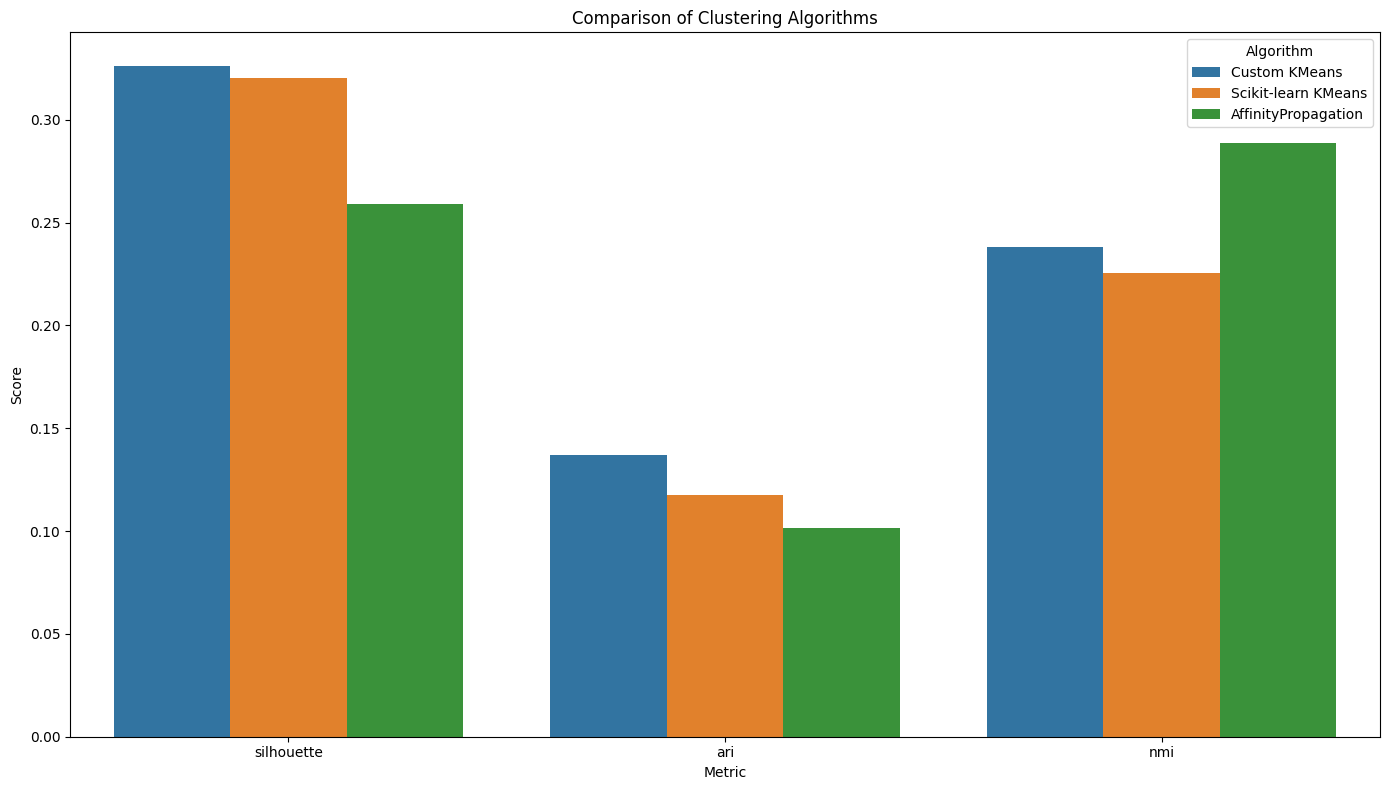

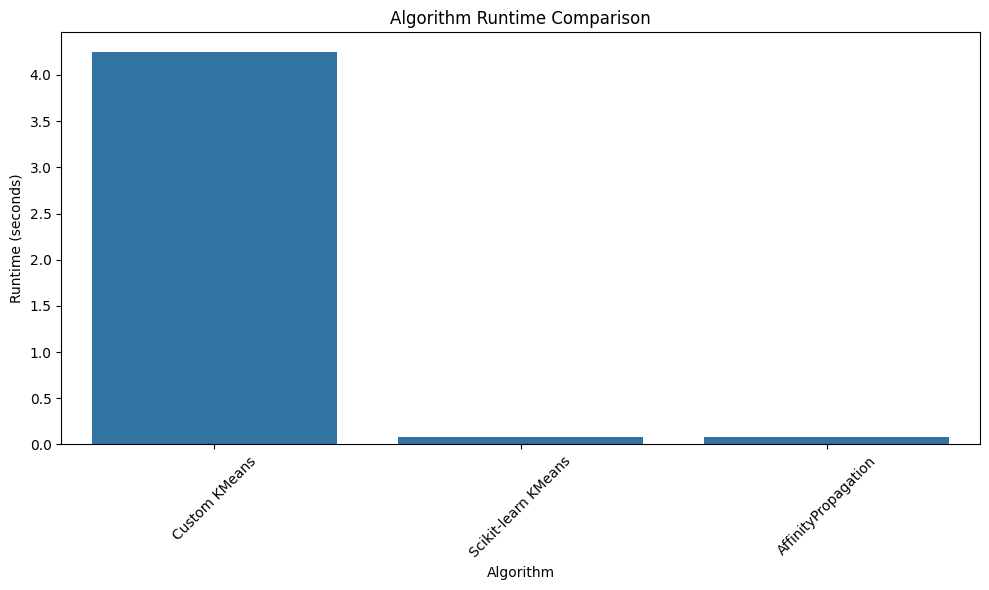


Running PCA with 35 components
Explained variance ratio: 1.0000
Searching hyperparameters for custom KMeans...
Testing 4 parameter combinations...


100%|██████████| 4/4 [00:50<00:00, 12.57s/it]


Best hyperparameters: {'n_clusters': np.int64(7), 'max_iter': np.int64(100), 'tol': np.float64(1e-05), 'random_state': np.int64(42)}
Best silhouette score: 0.3262

Searching hyperparameters for scikit-learn KMeans...
Testing 4 parameter combinations...


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


Best hyperparameters: {'n_clusters': np.int64(7), 'max_iter': np.int64(100), 'tol': np.float64(1e-05), 'random_state': np.int64(42), 'n_init': np.int64(10)}
Best silhouette score: 0.3204

Searching hyperparameters for AffinityPropagation...
Testing 12 parameter combinations...


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


Best hyperparameters: {'damping': np.float64(0.9), 'max_iter': np.int64(200), 'convergence_iter': np.int64(15), 'random_state': np.int64(42)}
Best silhouette score: 0.2590


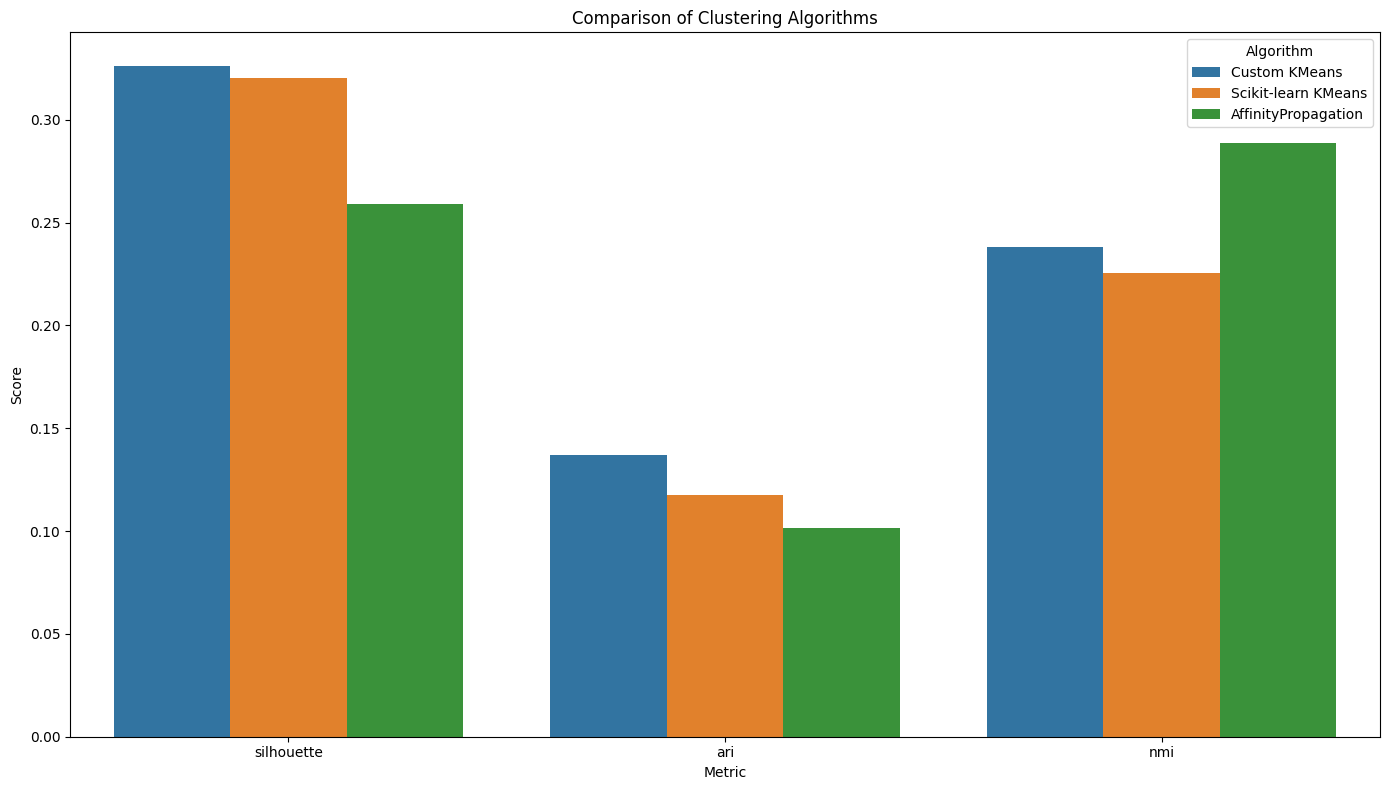

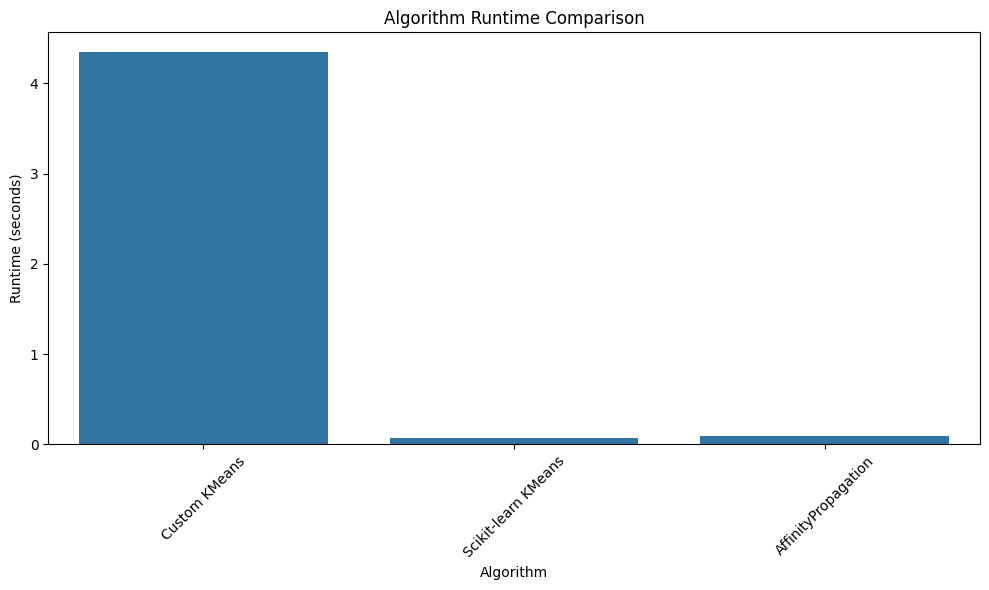


Running PCA with 40 components
Explained variance ratio: 1.0000
Searching hyperparameters for custom KMeans...
Testing 4 parameter combinations...


100%|██████████| 4/4 [00:50<00:00, 12.60s/it]


Best hyperparameters: {'n_clusters': np.int64(7), 'max_iter': np.int64(100), 'tol': np.float64(1e-05), 'random_state': np.int64(42)}
Best silhouette score: 0.3262

Searching hyperparameters for scikit-learn KMeans...
Testing 4 parameter combinations...


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Best hyperparameters: {'n_clusters': np.int64(7), 'max_iter': np.int64(100), 'tol': np.float64(1e-05), 'random_state': np.int64(42), 'n_init': np.int64(10)}
Best silhouette score: 0.3204

Searching hyperparameters for AffinityPropagation...
Testing 12 parameter combinations...


100%|██████████| 12/12 [00:03<00:00,  3.70it/s]


Best hyperparameters: {'damping': np.float64(0.9), 'max_iter': np.int64(200), 'convergence_iter': np.int64(15), 'random_state': np.int64(42)}
Best silhouette score: 0.2590


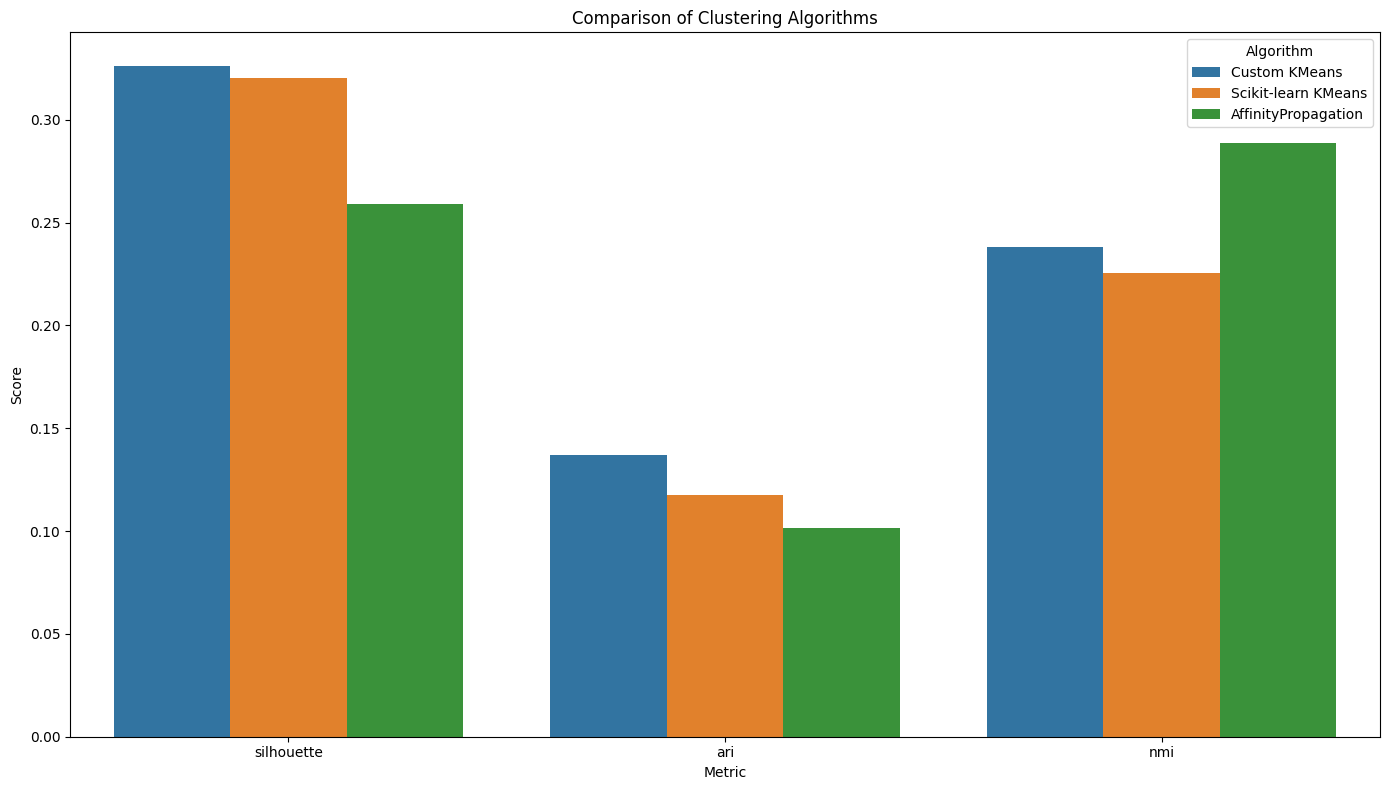

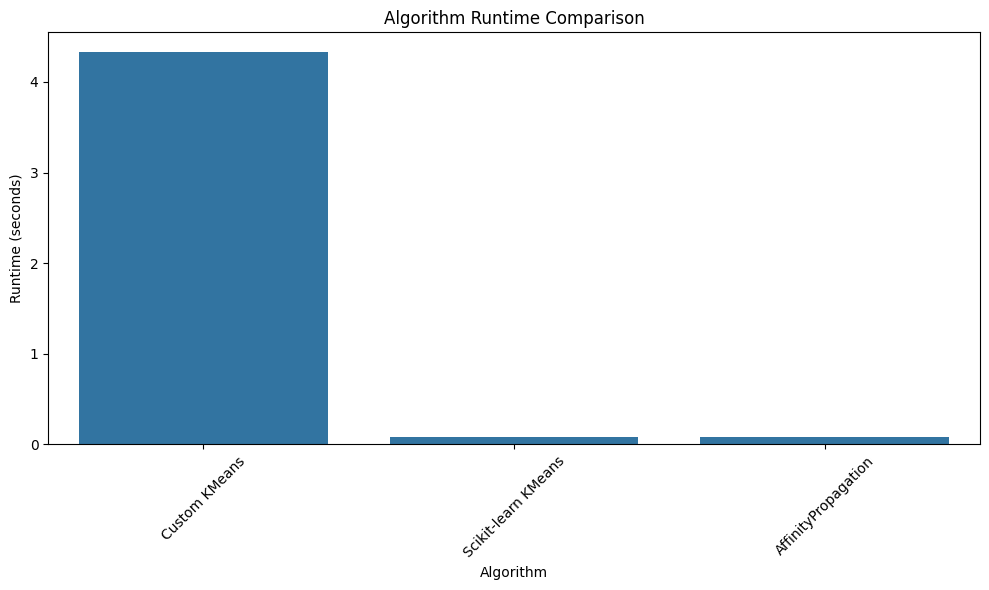


Running PCA with 45 components
Explained variance ratio: 1.0000
Searching hyperparameters for custom KMeans...
Testing 4 parameter combinations...


100%|██████████| 4/4 [00:50<00:00, 12.56s/it]


Best hyperparameters: {'n_clusters': np.int64(7), 'max_iter': np.int64(100), 'tol': np.float64(1e-05), 'random_state': np.int64(42)}
Best silhouette score: 0.3262

Searching hyperparameters for scikit-learn KMeans...
Testing 4 parameter combinations...


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Best hyperparameters: {'n_clusters': np.int64(7), 'max_iter': np.int64(100), 'tol': np.float64(1e-05), 'random_state': np.int64(42), 'n_init': np.int64(10)}
Best silhouette score: 0.3204

Searching hyperparameters for AffinityPropagation...
Testing 12 parameter combinations...


100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


Best hyperparameters: {'damping': np.float64(0.9), 'max_iter': np.int64(200), 'convergence_iter': np.int64(15), 'random_state': np.int64(42)}
Best silhouette score: 0.2590


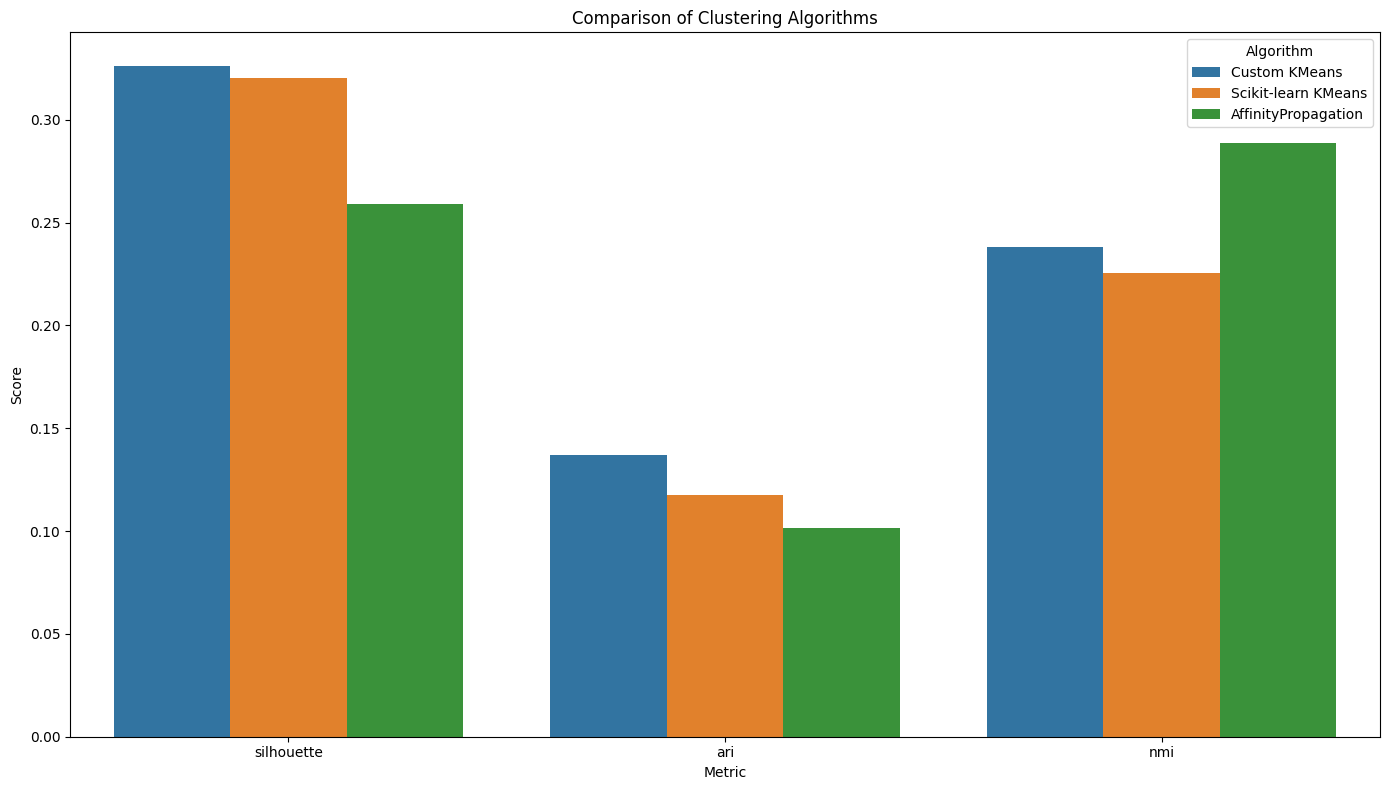

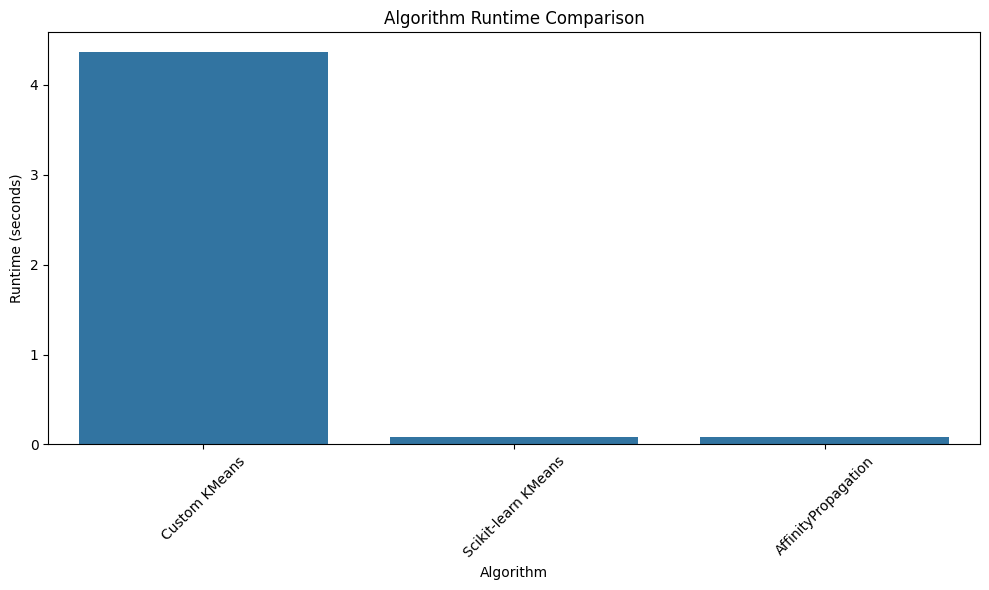

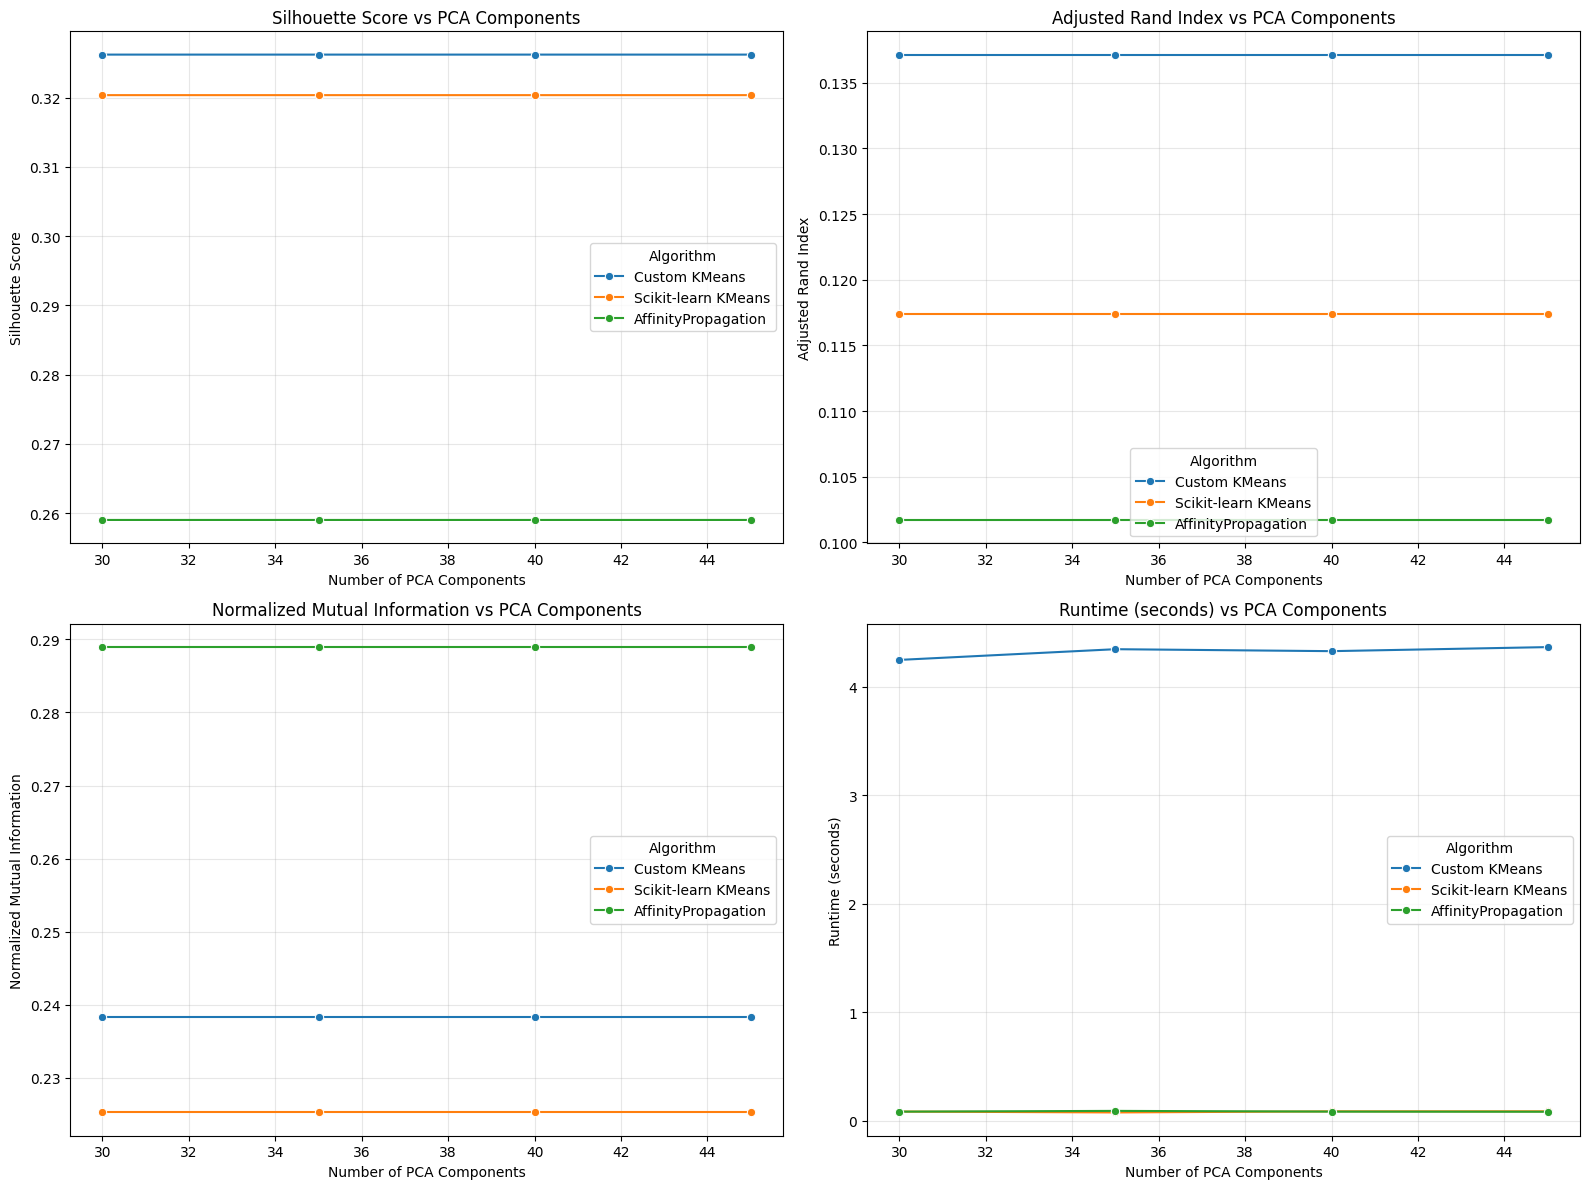

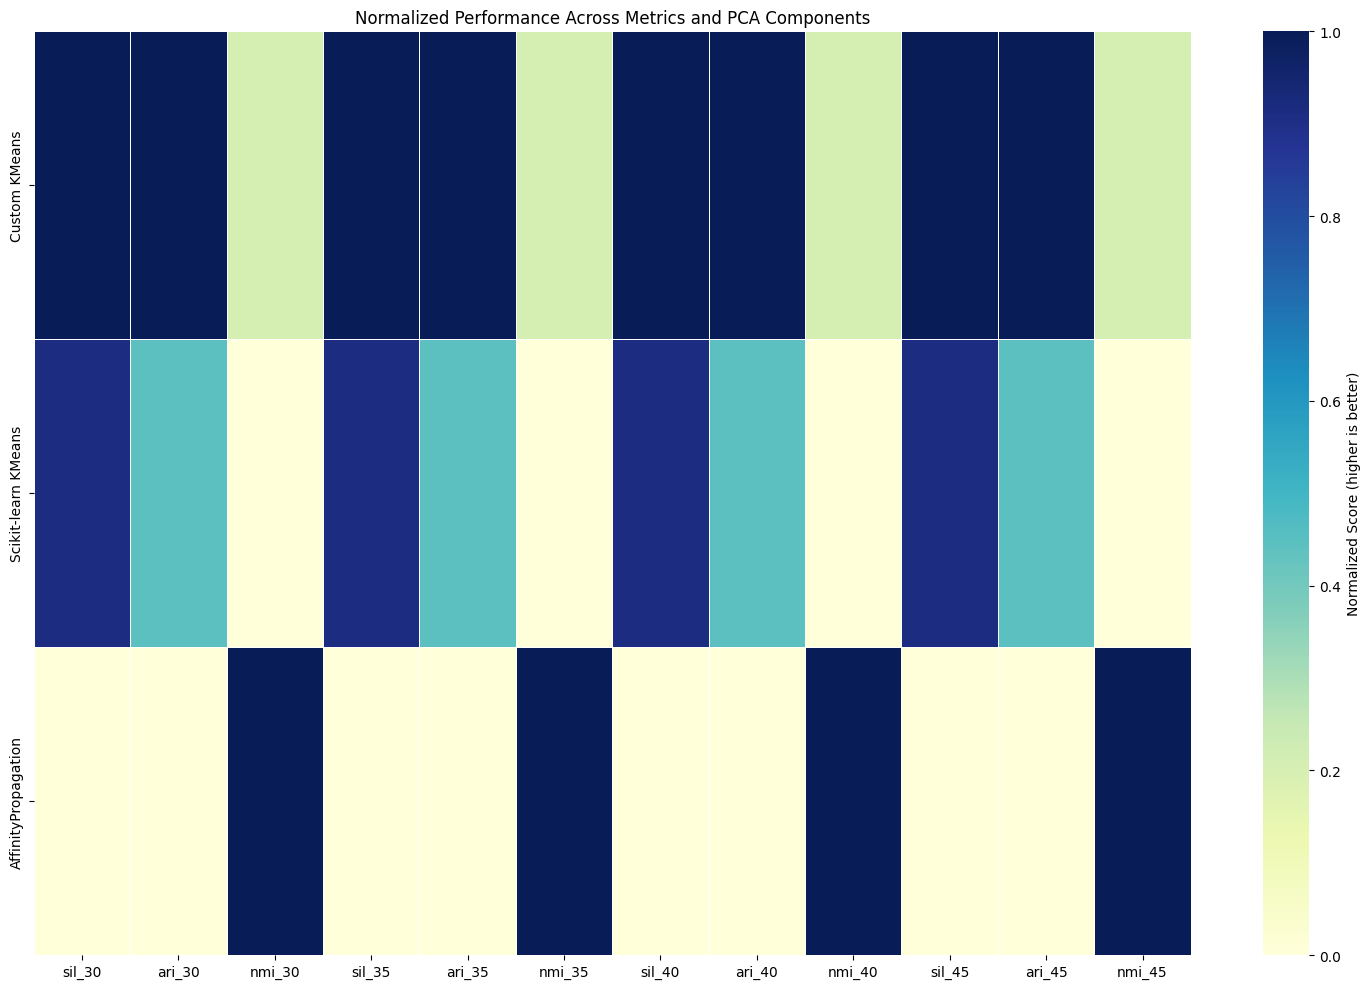

In [ ]:
all_results, comparison_dfs = run_pca_clustering(
    X=new_X, y=new_y, pca_components=[30, 35, 40, 45], n_samples=500
)

## Итог

В ходе работы были использованы и сравнены такие алгоритмы кластеризации как KMeans, Affinity Propogation, а также собственная реализация KMeans. Датасет содержал данные о различных типах лесного покрова.

Используя PCA и t-SNE, была сокращена размерность.

Были подобраны гиперпараметры для каждой из моделей. Были подсчитаны следующие метрики: silhouette_score, adjusted_rand_score (*ari*), normalized_mutual_info_score (*nmi*).

Лучше всего себя показала модель My_KMeans, а хуже всего AffinityPropagation (sklearn). При этом My_KMeans оказалась на последнем месте по скорости обучения с большим отрывом. Время обучения KMeans и AffinityPropagaion сравнимо.